# Initialization

In [47]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'
file_unemployment = 'state_unemployment_2013.csv'

# cosmetics for plots 
sns.set(font_scale = 1.5)

In [48]:
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

In [49]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses)
prescribers = pd.read_csv(file_prescribers)
unemployment = pd.read_csv(file_unemployment, index_col='State')

Data Sources: 
Opioid, overdose, and prescriber dataframes come from [US Opioid Prescriptions/Overdoses](https://www.kaggle.com/apryor6/us-opiate-prescriptions) Kaggle dataset.

Unemployment dataframe is from the [US Bureau of Labor Statistics](https://www.bls.gov/lau/lastrk13.htm)

### A few small cleaning tasks. 

In [50]:
overdoses = overdoses.set_index('State')
overdoses['Population']=overdoses['Population'].str.replace(',', '')
overdoses['Deaths']=overdoses['Deaths'].str.replace(',','')
overdoses[['Population', 'Deaths']]=overdoses[['Population','Deaths']].apply(pd.to_numeric)

# rename column because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);
# take prescribers from states only
prescribers_states = prescribers[~prescribers.Abbrev.isin(['AA', 'AE', 'GU', 'VI', 'ZZ'])]
# add prescriber information to overdose df 
prescribers_per_state = []
for index, row in overdoses.iterrows(): 
    prescribers_per_state.append(prescribers.loc[prescribers['Abbrev']==row['Abbrev']].shape[0])
overdoses['Prescribers'] = prescribers_per_state

# prescribers per capita
overdoses['Prescribers Per Capita'] = overdoses['Prescribers']/overdoses['Population']
overdoses['Prescribers Per 100,000'] = overdoses['Prescribers Per Capita'] * 100000
# overdoses per capita
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/ overdoses['Population']) 
overdoses['Deaths Per 100,000'] = overdoses['Deaths Per Capita']*100000

In [51]:
tracked_drugs = list(prescribers.columns)[5:-1]
def provider_drugs(npi, df= prescribers, track_list = tracked_drugs):
    '''
    Given a provider NPI, returns a list of the drugs the provider prescribed
    Grabs this info from the prescribers database unless otherwise instructed, 
    Grabs info about which drugs are being tracked from tracked_drugs (built from prescribers)
    unless otherwise noted. 
    
    With track_list = detected_opioids, this returns the (recognized) opioids the provdier has prescribed! :)
    '''
    row = df[prescribers.NPI==npi]
    all_drugs = row[track_list].transpose()
    all_drugs.columns = ['num_prescriptions']
    return list(all_drugs.iloc[all_drugs.num_prescriptions.nonzero()].index)

prescribers['prescribed_drugs'] = prescribers['NPI'].apply(provider_drugs)

In [52]:
prescribers.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,prescribed_drugs
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[HYDROCODONE.ACETAMINOPHEN, LORAZEPAM]"
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,35,1,"[ALPRAZOLAM, AMLODIPINE.BESYLATE, ATENOLOL, BU..."
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,25,0,"[BUPROPION.HCL.SR, BUPROPION.XL, CLONAZEPAM, D..."
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,1,"[ACETAMINOPHEN.CODEINE, ALENDRONATE.SODIUM, AM..."
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,17,28,0,0,0,1,"[AMITRIPTYLINE.HCL, FENTANYL, HYDROCODONE.ACET..."


In [53]:
specialty_counts = prescribers.Specialty.value_counts()
print('Total specialties recorded: {}'.format(len(specialty_counts)))
print('Specialties with > 100 prescribers recorded: {}'.format(len(specialty_counts[specialty_counts > 100])))

Total specialties recorded: 109
Specialties with > 100 prescribers recorded: 33


In [54]:
specialty_counts[specialty_counts > 100]

Internal Medicine                                                 3194
Family Practice                                                   2975
Dentist                                                           2800
Nurse Practitioner                                                2512
Physician Assistant                                               1839
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              615
Orthopedic Surgery                                                 575
Optometry                                                          571
Student in an Organized Health Care Education/Training Program     547
Ophthalmology                                                      519
General Surgery                                                    487
Gastro

In [55]:
# Which drugs are most often prescribed? 
top_20_drugs = prescribers[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:20].index
prescribers[tracked_drugs].aggregate(sum).sort_values(ascending = False).head()

LISINOPRIL              1176243
LEVOTHYROXINE.SODIUM    1144724
AMLODIPINE.BESYLATE     1107865
SIMVASTATIN             1032511
OMEPRAZOLE              1012238
dtype: int64

In [56]:
specialty_dummy = pd.get_dummies(prescribers['Specialty'])
dummy_prescribers = pd.concat([prescribers, specialty_dummy], axis = 1)
S = dummy_prescribers.copy().prescribed_drugs.apply(len)
dummy_prescribers = dummy_prescribers.assign(presc_drug_count = S.values)
dummy_columns = [i.strip() for i in specialty_dummy.columns]

In [57]:
dummy_prescribers.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,Student in an Organized Health Care Education/Training Program,Surgery,Surgical Oncology,Thoracic Surgery,Thoracic Surgery (Cardiothoracic Vascular Surgery),Unknown Physician Specialty Code,Unknown Supplier/Provider,Urology,Vascular Surgery,presc_drug_count
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,44
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


# Drug prescriptions based on specialty

For each of the most commonly prescribed drugs and all prescribers, we try to use prescriber specialty, the number of drugs the provider prescribes, and their opioid prescriber status to predict how much of each drug they will prescribe. 

In [58]:
scores = pd.Series(index = top_20_drugs)
for i in top_20_drugs: 
    reg = LinearRegression()
    X = dummy_prescribers[dummy_columns+ ['Opioid.Prescriber', 'presc_drug_count']] 
    y = dummy_prescribers[i].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state= 23) 

    reg.fit(X_train, y_train) 
    y_pred = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    scores[i] = score 

In [59]:
scores.loc[scores.values > .6]

LISINOPRIL              0.739329
LEVOTHYROXINE.SODIUM    0.748927
AMLODIPINE.BESYLATE     0.697501
SIMVASTATIN             0.707720
OMEPRAZOLE              0.721306
ATORVASTATIN.CALCIUM    0.641050
METFORMIN.HCL           0.702683
METOPROLOL.TARTRATE     0.622792
HYDROCHLOROTHIAZIDE     0.649892
dtype: float64

We slice the dataset to only take popular prescribers 

In [60]:
popular_prescribers = dummy_prescribers[dummy_prescribers.Specialty.isin(specialty_counts[specialty_counts > 100].index)]

In [61]:
popular_prescribers.shape

(23545, 367)

In [62]:
scores_popular = pd.Series(index = top_20_drugs)
for i in top_20_drugs: 
    reg = LinearRegression()
    X = popular_prescribers[dummy_columns+ ['Opioid.Prescriber', 'presc_drug_count']] 
    y = popular_prescribers[i].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state= 23) 

    reg.fit(X_train, y_train) 
    y_pred = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    scores_popular[i] = score 

In [63]:
scores_popular.loc[scores_popular.values > .6]

LISINOPRIL              0.725446
LEVOTHYROXINE.SODIUM    0.688866
AMLODIPINE.BESYLATE     0.709090
SIMVASTATIN             0.708054
OMEPRAZOLE              0.684445
ATORVASTATIN.CALCIUM    0.611289
METFORMIN.HCL           0.639714
HYDROCHLOROTHIAZIDE     0.656763
dtype: float64

Using only prescriber type, number of drugs prescribed in a year, and whether or not the prescriber prescribes opioids, we get reasonable prediction performance for drugs prescribed in a year. 

Let's take a closer look at performance for the case of predicting Lisinopril prescription numbers. 

In [64]:
lisinopril_reg = LinearRegression()
X = popular_prescribers[dummy_columns + ['Opioid.Prescriber', 'presc_drug_count']]
y = popular_prescribers.LISINOPRIL.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)
lisinopril_reg.fit(X_train, y_train)
y_pred = lisinopril_reg.predict(X_test)
score = lisinopril_reg.score(X_test, y_test)

residuals = (y_test - lisinopril_reg.predict(X_test))

In [65]:
print(score)

0.7254462987342492


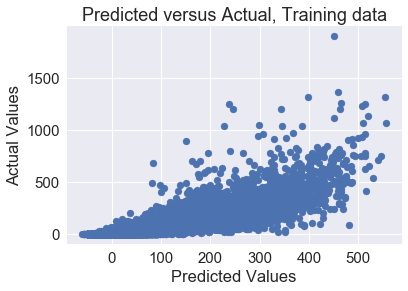

In [66]:
_ = plt.scatter(x=lisinopril_reg.predict(X_train), y=y_train)
_ = plt.title('Predicted versus Actual, Training data')
_ = plt.xlabel('Predicted Values')
_ = plt.ylabel('Actual Values')

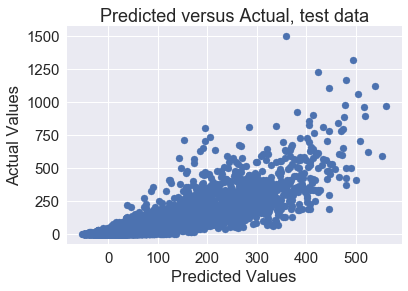

In [67]:
_ = plt.scatter(x=y_pred, y=y_test)
_ = plt.title('Predicted versus Actual, test data')
_ = plt.xlabel('Predicted Values')
_ = plt.ylabel('Actual Values')

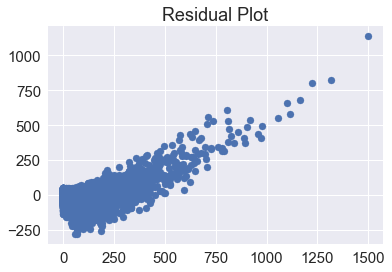

In [68]:
_ = plt.scatter(x=y_test, y = residuals)
_ = plt.title('Residual Plot')

The residual plot indicates a strong relationship between the target value and the error: this indicates that linear regression may not be performing as well as it could and that certain variable transformations could lead to improvement. 

The residual plot indicates both x- and y-axis unbalance. Y-axis unbalance typically indicates that the target variable might need to be transformed. X-axis unbalance might indicate that an explanatory variable needs to be transformed. These inbalances can also mean that we need additional explanatory variables. 

The easiest candidates to transform are the target variable and the total number of drugs prescribed by each provider. 

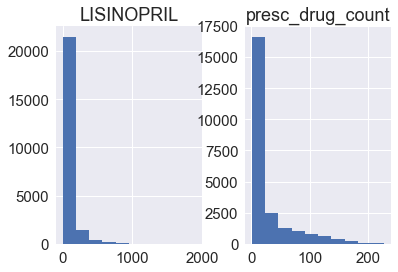

In [69]:
_ = popular_prescribers[['LISINOPRIL', 'presc_drug_count']].hist()

We will standard scale the variables, and also try seeing if taking a log might help. 

In [70]:
scaler = StandardScaler()
to_scale = popular_prescribers[['LISINOPRIL', 'presc_drug_count']]
scaler.fit(to_scale.values)
scaled = scaler.transform(to_scale.values)
logd = np.log1p(scaled)
popular_prescribers.loc[:,'LISINOPRIL.transf'] = logd[:,0].reshape(-1,1)
popular_prescribers.loc[:,'presc_drug_count_transf'] = logd[:,1].reshape(-1,1)

/home/rika/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/rika/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/rika/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/rika/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

The histograms after transformation are: 

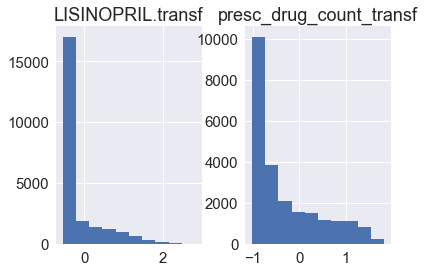

In [71]:
_ = popular_prescribers[['LISINOPRIL.transf', 'presc_drug_count_transf']].hist()

In [72]:
lisinopril_reg = LinearRegression()
X = popular_prescribers[dummy_columns + ['Opioid.Prescriber', 'presc_drug_count_transf']]
y = popular_prescribers['LISINOPRIL.transf'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)
lisinopril_reg.fit(X_train, y_train)
y_pred = lisinopril_reg.predict(X_test)
score = lisinopril_reg.score(X_test, y_test)

residuals = (y_test - lisinopril_reg.predict(X_test))

In [73]:
print(score)

0.8115615535539369


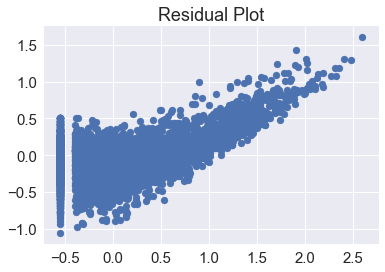

In [74]:
_ = plt.scatter(x=y_test, y = residuals)
_ = plt.title('Residual Plot')

The score has improved, but the residuals don't look so great. We'll try reverting to the original prescription drug count and taking the transformed target variable. 

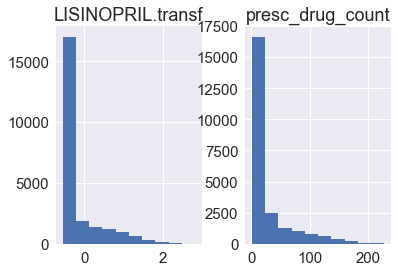

In [75]:
_ = popular_prescribers[['LISINOPRIL.transf', 'presc_drug_count']].hist()

In [76]:
lisinopril_reg = LinearRegression()
X = popular_prescribers[dummy_columns + ['Opioid.Prescriber', 'presc_drug_count']]
y = popular_prescribers['LISINOPRIL.transf'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)
lisinopril_reg.fit(X_train, y_train)
y_pred = lisinopril_reg.predict(X_test)
score = lisinopril_reg.score(X_test, y_test)

residuals = (y_test - lisinopril_reg.predict(X_test))

In [77]:
print(score)

0.8575017598949138


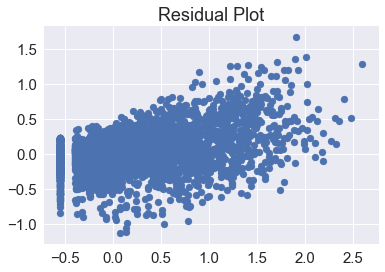

In [78]:
_ = plt.scatter(x=y_test, y = residuals)
_ = plt.title('Residual Plot')

The residuals look much better here. 

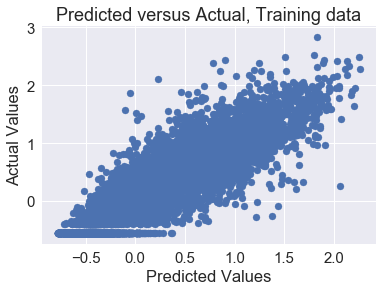

In [79]:
_ = plt.scatter(x=lisinopril_reg.predict(X_train), y=y_train)
_ = plt.title('Predicted versus Actual, Training data')
_ = plt.xlabel('Predicted Values')
_ = plt.ylabel('Actual Values')

If our target value is $t$, our model now predicts $\log(1+\hat{t})$, where $\hat{t} = \frac{t - \mu}{\sigma}$ is the standardized value of $t$ given $\mu$ and $\sigma$ from the Lisinopril measurements. 

To calculate the actual predicted number of Lisinopril prescriptions, given the value $p$ predicted by the model, we simply need to calculate 
$t = \sigma(\exp (p) -1) + \mu$

Now we'll see how this simple exponential transformation to the target variable affects performance for other drugs. 

In [83]:
scaler = StandardScaler()
top_19_drugs = [drug for drug in top_20_drugs if drug != 'LISINOPRIL']
to_scale = popular_prescribers[top_19_drugs]
scaler.fit(to_scale.values)
scaled = scaler.transform(to_scale.values)
logd = np.log1p(scaled)
transf_drugs_df = pd.DataFrame(logd, columns = ['{}.transf'.format(drug) for drug in top_19_drugs])
popular_prescribers_transf = pd.concat([popular_prescribers, transf_drugs_df], axis=1 ).fillna(0)
popular_prescribers_transf.loc[:, dummy_columns] = popular_prescribers_transf[dummy_columns].astype(np.int64)

/home/rika/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/rika/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
lisinopril_reg = LinearRegression()
X = popular_prescribers[dummy_columns + ['Opioid.Prescriber', 'presc_drug_count']]
y = popular_prescribers['LISINOPRIL.transf'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)
lisinopril_reg.fit(X_train, y_train)
y_pred = lisinopril_reg.predict(X_test)
score = lisinopril_reg.score(X_test, y_test)

residuals = (y_test - lisinopril_reg.predict(X_test))

In [85]:
scores_popular = pd.Series(index = top_20_drugs)
for drug in top_20_drugs: 
    reg = LinearRegression()
    X = popular_prescribers_transf[dummy_columns+ ['Opioid.Prescriber', 'presc_drug_count']] 
    y = popular_prescribers_transf['{}.transf'.format(drug)].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state= 23) 

    reg.fit(X_train, y_train) 
    y_pred = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    scores_popular[drug] = score 

In [87]:
scores_popular.loc[scores_popular.values > .6]

LISINOPRIL    0.865551
dtype: float64

In [115]:
scores_popular

LISINOPRIL                   0.865551
LEVOTHYROXINE.SODIUM        -0.002536
AMLODIPINE.BESYLATE         -0.002976
SIMVASTATIN                 -0.003443
OMEPRAZOLE                  -0.002606
ATORVASTATIN.CALCIUM        -0.003173
HYDROCODONE.ACETAMINOPHEN   -0.003023
FUROSEMIDE                  -0.003947
METFORMIN.HCL               -0.003275
METOPROLOL.TARTRATE         -0.003010
GABAPENTIN                  -0.002703
LOSARTAN.POTASSIUM          -0.003092
HYDROCHLOROTHIAZIDE         -0.002186
METOPROLOL.SUCCINATE        -0.003511
WARFARIN.SODIUM             -0.004637
CLOPIDOGREL                 -0.001714
PRAVASTATIN.SODIUM          -0.002552
CARVEDILOL                  -0.003543
TRAMADOL.HCL                -0.003582
ALPRAZOLAM                  -0.002576
dtype: float64

The exponential transformation results in a significant improvement for predicting Lisinopril prescription numbers, but performs worse than guessing the mean value for all other drugs. 

The implication here is that tuning of the linear regression model must take place on a drug-by-drug basis. 

# Specialty Classification based on drug prescriptions 

In [88]:
specialties = ['Psychiatry', 'Cardiology', 'Obstetrics/Gynecology', 'Orthopedic Surgery', 'Optometry', 'Opthalmology']
specialist_slice = prescribers[prescribers.Specialty.isin(specialties)]

Here are the most commonly prescribed drugs for these specialities:

In [89]:
specialist_slice[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:20]

ATORVASTATIN.CALCIUM         130227
LISINOPRIL                   109277
METOPROLOL.SUCCINATE         108367
CARVEDILOL                   106645
CLOPIDOGREL                  103138
AMLODIPINE.BESYLATE           98583
METOPROLOL.TARTRATE           97207
FUROSEMIDE                    91187
CLONAZEPAM                    76292
SIMVASTATIN                   74449
WARFARIN.SODIUM               71338
LOSARTAN.POTASSIUM            65562
QUETIAPINE.FUMARATE           59376
ALPRAZOLAM                    59059
HYDROCODONE.ACETAMINOPHEN     56295
TRAZODONE.HCL                 55802
ISOSORBIDE.MONONITRATE.ER     52857
RISPERIDONE                   50600
PRAVASTATIN.SODIUM            43700
LORAZEPAM                     43221
dtype: int64

In [90]:
specialist_top_10 = specialist_slice[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:10].index

In [91]:
specialist_slice.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,prescribed_drugs
8,1023260569,M,TX,O.D.,Optometry,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[CIPROFLOXACIN.HCL, DORZOLAMIDE.TIMOLOL, LATAN..."
13,1548275050,M,OH,MD,Cardiology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[FUROSEMIDE, LISINOPRIL, METOPROLOL.SUCCINATE]"
20,1083907059,M,UT,M.D.,Obstetrics/Gynecology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[OXYCODONE.HCL]
49,1295742583,M,KS,O.D.,Optometry,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[LATANOPROST, TIMOLOL.MALEATE, TRAVATAN.Z]"
51,1902866106,F,LA,M.D.,Obstetrics/Gynecology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[ALENDRONATE.SODIUM, ESTRADIOL, FLUCONAZOLE, I..."


In [92]:
X = specialist_slice[specialist_top_10].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [93]:
logreg.classes_

array(['Cardiology', 'Obstetrics/Gynecology', 'Optometry',
       'Orthopedic Surgery', 'Psychiatry'], dtype=object)

We take a look at the confusion matrix: ideally, we would only have nonzero entries along the diagonal (then classification is perfect). Nonzero entries off the diagonal indicate misclassifications. 

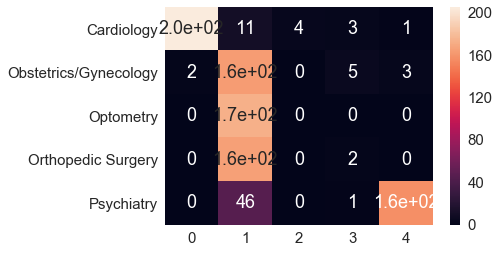

In [94]:
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion, annot=True)

In [95]:
logreg.score(X_test, y_test)

0.5605095541401274

Taking the 10 most popular drugs among the specialties allows us to distinguish between Cardiology, Psychiatry, and Obstetrics/Gynecology specialists, but distinction is poor for the other three classes. 

Taking all tracked drugs gives us a significant improvement. 

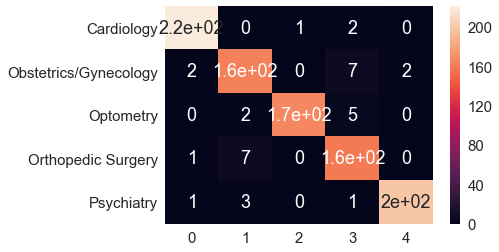

In [96]:
X = specialist_slice[tracked_drugs].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion, annot=True)

In [97]:
logreg.score(X_test, y_test)

0.9639065817409767

To evaluate the performance of the logistic regression, we would like to plot ROC curves. ROC curves are generally implemented in the binary classification case. 

So we modify the logistic regression here a bit. In the implementation above, we selected multinomial optimization: this minimizes "the multinomial loss fit across the entire probability distribution" [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](sklearn LogisticRegression docs). 

If we instead use a OneVsRest implementation with a logistic regression classifier under the hood, we are able to calculate individual ROC curves for the 5 binary subproblems (classify Cardiology vs Non-Cardiology specialty, etc). We can then plot these individual ROC curves and take a look at the AUC to gauge performance. 

In [98]:
# this implementation adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

specialty_list = ['Cardiology', 'Obstetrics/Gynecology', 'Optometry', 'Orthopedic Surgery', 'Psychiatry']
y = label_binarize(y, classes=specialty_list)
n_classes = y.shape[1]

# Add noisy features to make the problem harder
n_samples, n_features = X.shape

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
score = classifier.score(X_test, y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, specialty in enumerate(specialty_list):
    fpr[specialty], tpr[specialty], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[specialty] = auc(fpr[specialty], tpr[specialty])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [99]:
print(score)

0.9535031847133758


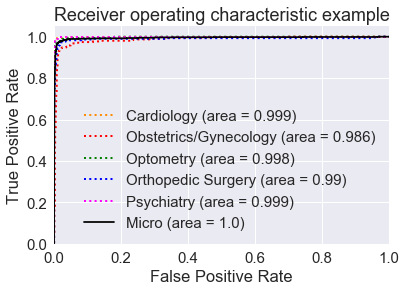

<Figure size 432x288 with 0 Axes>

In [125]:
# also adapted from sklearn docs
plt.figure()
lw = 2
colors = ['darkorange', 'red', 'green', 'blue', 'magenta']
for i, specialty in enumerate(specialty_list):
    plt.plot(fpr[specialty], tpr[specialty], color=colors[i],
         lw=lw, label='{} (area = {})'.format(specialty, np.round(roc_auc[specialty],3)), linestyle=':')
plt.plot(fpr['micro'], tpr['micro'], color='black', 
         label = 'Micro (area = {})'.format(np.round(roc_auc['micro'])))
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
_ = plt.savefig('ROC.png')

Taking all drugs in the dataset, we see that we can easily distinguish between doctors of different selected specialties with only a few misclassifications. 

An interesting further problem would be to try to reduce the number of features.

In [101]:
nonzero_col = specialist_slice.groupby('Specialty').sum().apply(lambda col: col> 0).sum().sort_values(ascending=True)
by_no_specialties = specialist_slice.groupby('Specialty')[nonzero_col.index].sum()

In [102]:
cols = by_no_specialties.columns
by_no_specialties

,NIACIN.ER,KLOR.CON.10,TOPROL.XL,IRBESARTAN,FLOVENT.HFA,BENICAR.HCT,INSULIN.SYRINGE,BRIMONIDINE.TARTRATE,BUMETANIDE,MORPHINE.SULFATE,...,METOPROLOL.TARTRATE,MIRTAZAPINE,MONTELUKAST.SODIUM,NAMENDA,OMEPRAZOLE,POTASSIUM.CHLORIDE,PRAVASTATIN.SODIUM,QUETIAPINE.FUMARATE,SIMVASTATIN,Opioid.Prescriber
Specialty,,,,,,,,,,,,,,,,,,,,,
Cardiology,3814,2374,5552,5888,14,2605,555,0,4140,0,...,95545,338,2088,1034,14661,28632,42330,391,72002,162
Obstetrics/Gynecology,0,0,0,0,0,103,36,0,34,25,...,539,50,153,82,868,453,589,104,702,144
Optometry,0,0,0,0,0,0,0,4565,0,0,...,39,11,14,11,11,12,11,13,33,3
Orthopedic Surgery,0,0,0,0,0,0,0,17,0,0,...,705,168,266,273,1049,715,651,131,1008,567
Psychiatry,0,0,0,0,0,0,0,0,0,66,...,379,27150,71,5780,1307,219,119,58737,704,78


In [103]:
candidate_drugs = ['INSULIN.SYRINGE', 'BRIMONIDINE.TARTRATE', 'MORPHINE.SULFATE', 'METOLAZONE', 'LITHIUM.CARBONATE', 'TRAVATAN.Z', 'GLIPIZIDE.XL', 'RESTASIS', 'FELODIPINE.ER', 'GLYBURIDE']

0.47876857749469215


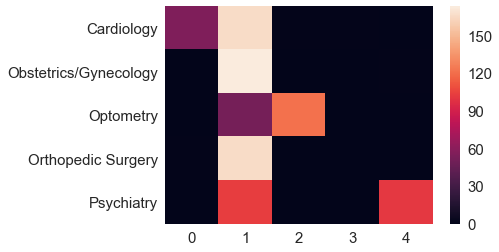

In [104]:
X = specialist_slice[candidate_drugs].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion)
print(logreg.score(X_test,y_test))

In [105]:
by_no_specialties[candidate_drugs]

,INSULIN.SYRINGE,BRIMONIDINE.TARTRATE,MORPHINE.SULFATE,METOLAZONE,LITHIUM.CARBONATE,TRAVATAN.Z,GLIPIZIDE.XL,RESTASIS,FELODIPINE.ER,GLYBURIDE
Specialty,,,,,,,,,,
Cardiology,555,0,0,3787,0,25,319,69,772,521
Obstetrics/Gynecology,36,0,25,0,15,0,0,0,0,22
Optometry,0,4565,0,0,0,12203,0,12828,0,0
Orthopedic Surgery,0,17,0,56,0,0,36,0,0,60
Psychiatry,0,0,66,0,13031,0,0,0,13,0


A possible way forward would be to try to optimize the number of drugs used as explanatory variables based on the number of specialties prescribe them (and what those specialties are)